In [2]:
import napari 
from dataset import BlastoDataset
import numpy as np 


In [3]:
viewer=napari.Viewer()

In [4]:
from model import UNet
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

unet = UNet(depth=4, in_channels=1, out_channels=4, num_fmaps=2).to(device)
state=torch.load('/group/dl4miacourse/projects/BlastoSeg/boundary_prediction_lr00001_weighted.pth')
unet.load_state_dict(state)

<All keys matched successfully>

In [5]:
from torch.utils.data import DataLoader

val_data = BlastoDataset("/group/dl4miacourse/projects/BlastoSeg/validation")
val_loader = DataLoader(val_data, batch_size = 1, shuffle=True, num_workers=4)

In [53]:
import matplotlib.pyplot as plt
unet.eval()
with torch.no_grad():
    stacked_predictions = []
    stacked_groundtruth = []
    stacked_images = []
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # Initialize temporary loss accumulator for this batch
        val_loss = 0

        print(torch.unique(y_batch))
        # Loop over each slice in the batch
        
        for slice_id in range(x_batch.shape[1]):
            x = x_batch[:, slice_id:slice_id + 1, ...]
            y = y_batch[:, slice_id:slice_id + 1, ...]

            x = x.permute(1, 0, 2, 3)
            y = y.permute(1, 0, 2, 3)
            y = torch.squeeze(y, 1)

            # Apply model and calculate prediction
            prediction = unet(x)
            prediction = prediction.argmax(1)

            # Append prediction to the list
            stacked_predictions.append(prediction)
            stacked_groundtruth.append(y)
            stacked_images.append(x)
    # Concatenate along the slice dimension
    stacked_predictions = torch.stack(stacked_predictions, dim=1)
    stacked_groundtruth = torch.stack(stacked_groundtruth, dim=1)
    stacked_images = torch.stack(stacked_images, dim=2)
    # viewer.add_image(stacked_predictions.cpu().numpy(), name='Predictions', colormap='gist_gray')
    # viewer.add_image(stacked_groundtruth.cpu().numpy(), name='Groundtruth', colormap='gist_gray')
    # viewer.add_image(stacked_images.cpu().numpy(), name='Images', colormap='gist_gray')
    stacked_predictions = stacked_predictions.cpu().numpy()
    stacked_groundtruth = stacked_groundtruth.cpu().numpy()
    stacked_images = stacked_images.cpu().numpy()

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3], device='cuda:0')


In [54]:
stacked_predictions = np.array(stacked_predictions[0])
stacked_groundtruth = np.array(stacked_groundtruth[0])
stacked_images = np.array(stacked_images[0, 0])
stacked_groundtruth.shape
stacked_images.shape

(236, 256, 256)

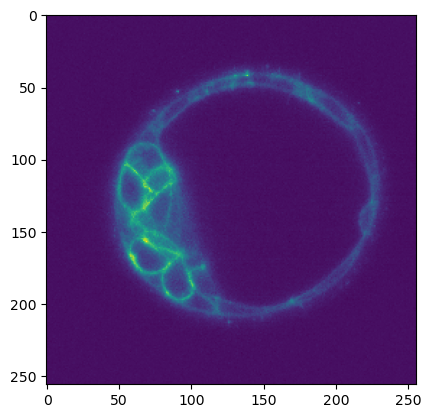

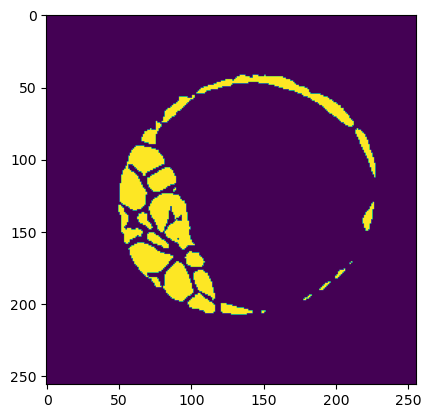

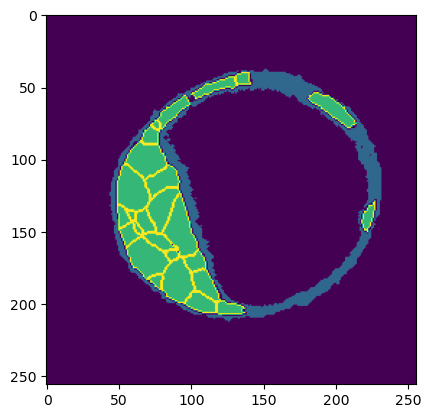

In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Assuming stacked_predictions, stacked_groundtruth, and stacked_images are numpy arrays
# Assuming each stack has dimensions (number of images, 256, 256)

# Loop over all predictions and set number 3 to 0
for i in range(len(stacked_predictions)):
    stacked_predictions[i][stacked_predictions[i] == 3] = 0
# Choose a random index for the image
plt.imshow(stacked_images[50])
plt.show()
plt.imshow(stacked_predictions[50])
plt.show()

plt.imshow(stacked_groundtruth[50])
plt.show()


In [70]:
from skimage.morphology import remove_small_objects
from scipy.ndimage import label, maximum_filter
from skimage.segmentation import watershed
from scipy import ndimage as ndi
def watershed_from_boundary_distance(
    boundary_distances: np.ndarray,
    inner_mask: np.ndarray,
    id_offset: float = 0,
    min_seed_distance: int = 20,
):
    """Function to compute watershed from boundary distances."""

    # Find local maxima
    seeds, _ = find_local_maxima(boundary_distances, min_seed_distance)

    # If no local maxima found, return an empty segmentation
    if np.max(seeds) == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    # Increment seeds by id_offset
    seeds[seeds != 0] += id_offset

    # Calculate watershed segmentation
    segmentation = watershed(
        boundary_distances.max() - boundary_distances, markers=seeds, mask=inner_mask
    )

    # Remove small objects from segmentation
    segmentation = remove_small_objects(segmentation, min_size=10)

    return segmentation

def get_inner_mask(pred, threshold):
    inner_mask = pred > threshold
    return inner_mask

def find_local_maxima(distance_transform, min_dist_between_points):
    # Use `maximum_filter` to perform a maximum filter convolution on the distance_transform
    max_filtered = maximum_filter(distance_transform, min_dist_between_points)
    maxima = max_filtered == distance_transform
    # Uniquely label the local maxima
    seeds, n = label(maxima)

    return seeds, n

# Perform watershed segmentation on each image in stacked_predictions
segmented_images = []
for i in range(len(stacked_predictions)):
    inner_mask = get_inner_mask(stacked_predictions[i], threshold=0.5)
    distance_transform = ndi.distance_transform_edt(stacked_predictions[i])
    segmentation = watershed_from_boundary_distance(
        boundary_distances=distance_transform, 
        inner_mask=inner_mask
    )
    segmented_images.append(segmentation)

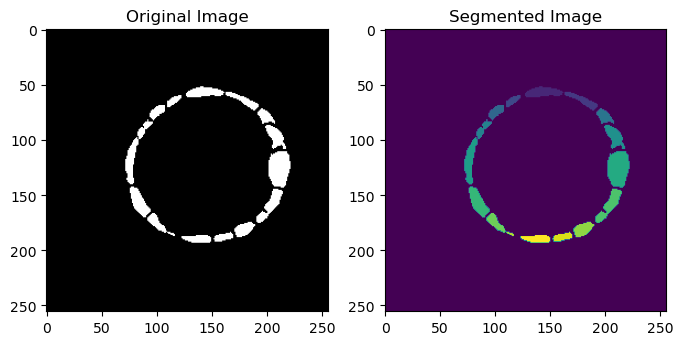

In [56]:
# Finding local maxima as seeds for the watershed

import numpy as np
import random
import matplotlib.pyplot as plt

# Define the watershed_from_boundary_distance function
def watershed_from_boundary_distance(
    boundary_distances: np.ndarray,
    inner_mask: np.ndarray,
    id_offset: float = 0,
    min_seed_distance: int = 10,
):
    """Function to compute a watershed from boundary distances."""

    seeds, n = find_local_maxima(boundary_distances, min_seed_distance)

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds != 0] += id_offset

    # calculate our segmentation
    segmentation = watershed(
        boundary_distances.max() - boundary_distances, seeds, mask=inner_mask
    )

    return segmentation

def get_inner_mask(pred, threshold):
    inner_mask = pred > threshold
    return inner_mask
from scipy.ndimage import label, maximum_filter
from skimage.segmentation import watershed
def find_local_maxima(distance_transform, min_dist_between_points):
    # Use `maximum_filter` to perform a maximum filter convolution on the distance_transform
    max_filtered = maximum_filter(distance_transform, min_dist_between_points)
    maxima = max_filtered == distance_transform
    # Uniquely label the local maxima
    seeds, n = label(maxima)

    return seeds, n
# Perform watershed segmentation on each image in stacked_predictions
segmented_images = []
for i in range(len(stacked_predictions)):
    inner_mask = get_inner_mask(stacked_predictions[i], threshold=0.5)
    segmentation = watershed_from_boundary_distance(
        boundary_distances=stacked_predictions[i], 
        inner_mask=inner_mask
    )
    segmented_images.append(segmentation)

# Choose a random index for the image
random_index = random.randint(0, len(stacked_predictions) - 1)

# Plot the segmented image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(stacked_predictions[random_index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_images[random_index], cmap='viridis')
plt.title('Segmented Image')

plt.show()


Text(0.5, 1.0, 'Segmented Image')

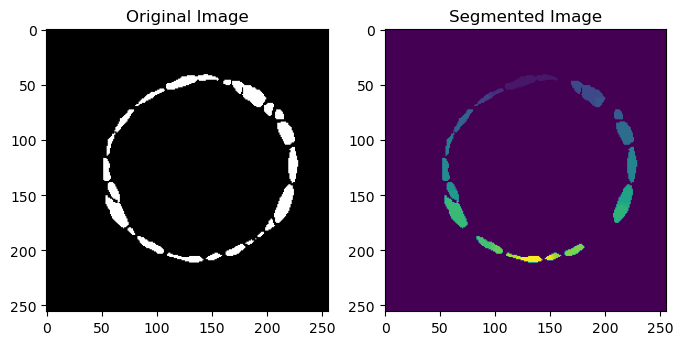

In [74]:
# Choose a random index for the image
random_index = random.randint(0, len(stacked_predictions) - 1)

# Plot the segmented image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(stacked_predictions[random_index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.array(segmented_images[random_index]), cmap='viridis')
plt.title('Segmented Image')

In [61]:
import numpy as np
import napari

# Split all stacks into two parts
stacked_images_1 = stacked_images[:stacked_images.shape[1]//2]
stacked_images_2 = stacked_images[stacked_images.shape[1]//2:]

# Split segmented_images accordingly
segmented_images_np = np.array(segmented_images)
segmented_images_1 = segmented_images_np[:len(segmented_images)//2]
segmented_images_2 = segmented_images_np[len(segmented_images)//2:]

# Split all ground truth stacks into two parts
stacked_groundtruth_1 = stacked_groundtruth[:stacked_groundtruth.shape[1]//2]
stacked_groundtruth_2 = stacked_groundtruth[stacked_groundtruth.shape[1]//2:]

# Assuming stacked_images_1, stacked_images_2, segmented_images_1, segmented_images_2,
# stacked_groundtruth_1, and stacked_groundtruth_2 are numpy arrays
# Open napari viewer
with napari.gui_qt():
    # Create a viewer
    viewer = napari.Viewer()

    # Add stacked images 1 and 2 to viewer
    viewer.add_image(stacked_images_1, name='Stacked Images 1', colormap='gray')
    viewer.add_image(stacked_images_2, name='Stacked Images 2', colormap='gray')

    # Add segmented images 1 and 2 to viewer
    viewer.add_image(segmented_images_1, name='Segmented Images 1', colormap='gray')
    viewer.add_image(segmented_images_2, name='Segmented Images 2', colormap='gray')

    # Add stacked ground truth 1 and 2 to viewer
    viewer.add_image(stacked_groundtruth_1, name='Stacked Ground Truth 1', colormap='gray')
    viewer.add_image(stacked_groundtruth_2, name='Stacked Ground Truth 2', colormap='gray')



/localscratch/miniforge3/envs/segmentation/lib/python3.10/contextlib.py:135: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)


In [ ]:
viewer.add_image(np.array(segmented_images), name='Images', colormap='gist_gray')
